In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import brotli
import os
import json
# import infomap



C:\Users\ezio1\AppData\Local\Temp\ipykernel_53132\2852969634.py:1: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\H_A_S_allCSV\ALL_COMMUNITY_merged.csv.gz', compression='gzip')


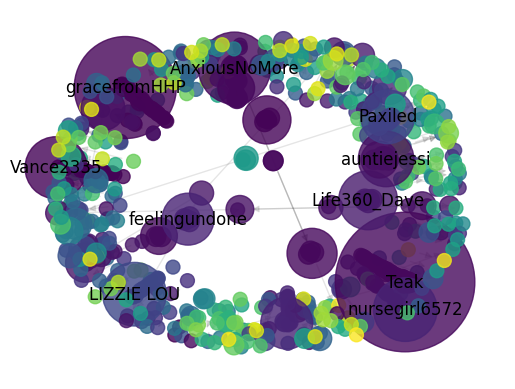

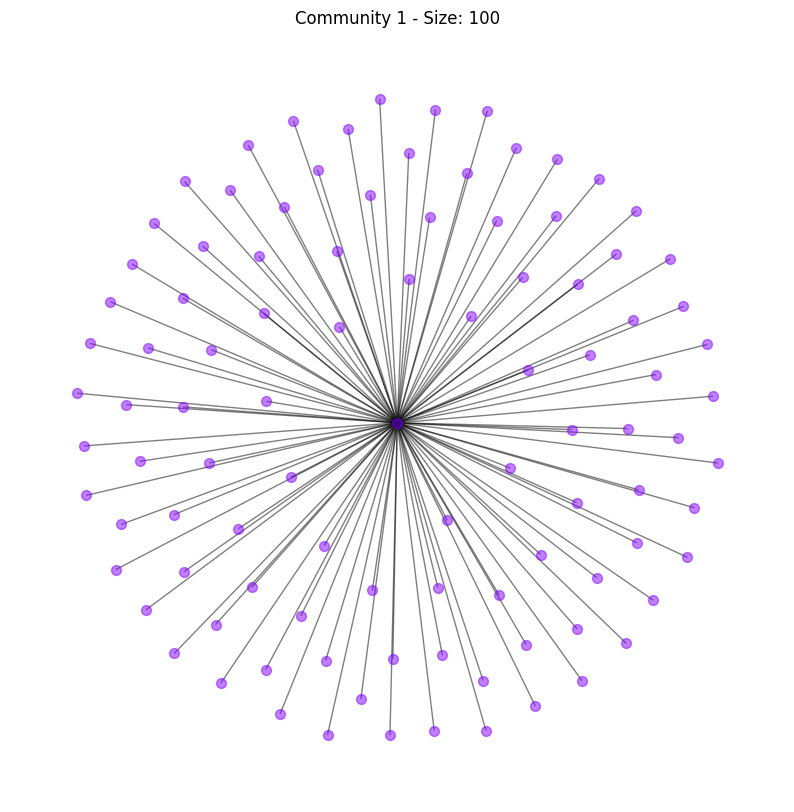

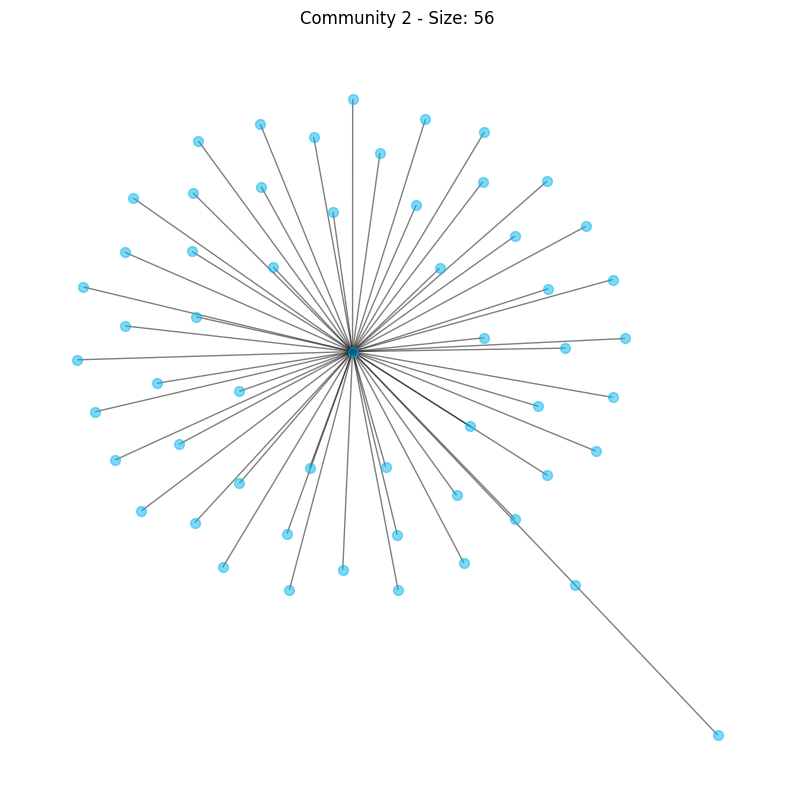

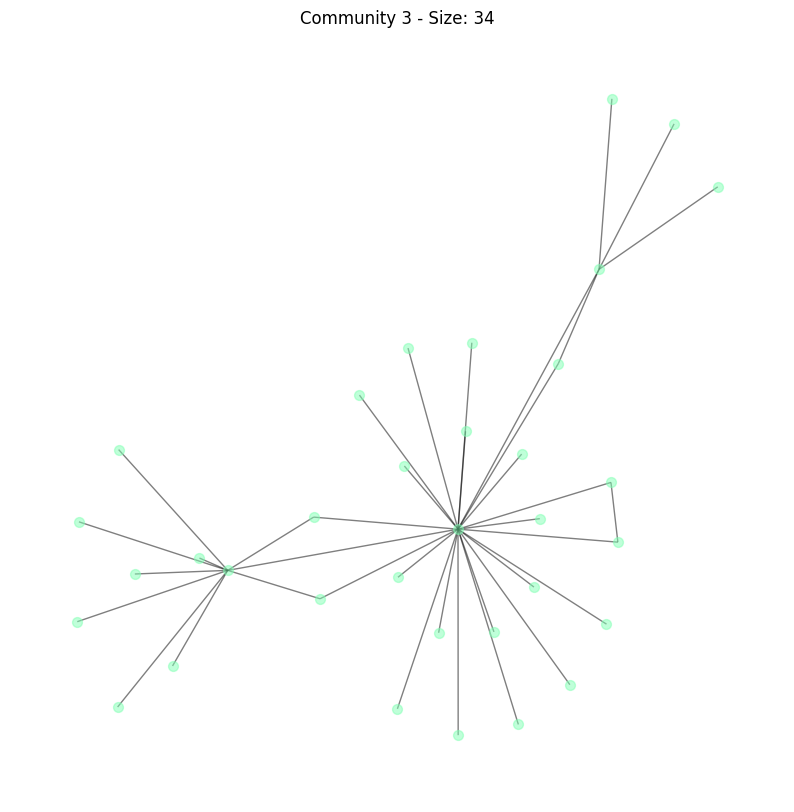

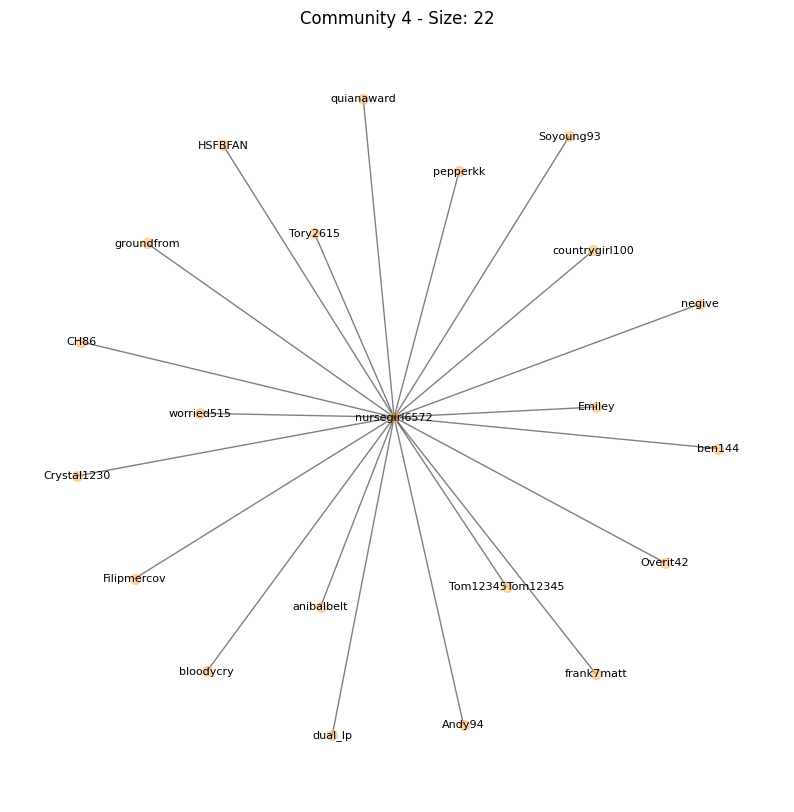

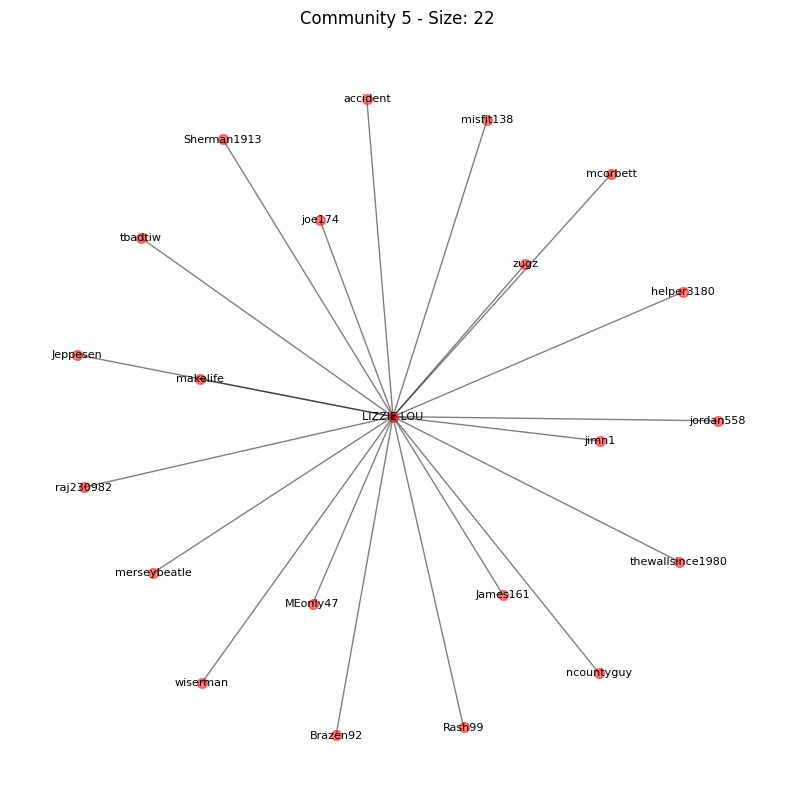

In [15]:
merged_df = pd.read_csv(r'C:\Users\ezio1\Documents\NLP docs\H_A_S_allCSV\ALL_COMMUNITY_merged.csv.gz', compression='gzip') 
#randomly select 1000 rows
merged_df = merged_df.sample(n=1000)

# Define the path for saving plots
plot_path = 'plots/'

# Ensure the directory exists
os.makedirs(plot_path, exist_ok=True)


# Now extract unique usernames from relevant columns
# We need to handle NaN values as there may be missing data in replies and comments
unique_usernames = pd.concat([
    merged_df['question_user_name'].dropna(),
    merged_df['ans_users_name'].dropna(),
    merged_df['comment_users_name'].dropna()
]).unique()

# Initialize an empty directed graph
G = nx.DiGraph()

# Add nodes for each unique username
for username in unique_usernames:
    G.add_node(username)

# Function to add or update an edge with weight, excluding self-interactions
def add_or_update_edge(G, source, target):
    # Check if source and target are the same to avoid self-loops
    if source == target:
        return  # Do not add an edge if a user is interacting with themselves
    
    if G.has_edge(source, target):
        # If the edge already exists, increment the weight
        G[source][target]['weight'] += 1
    else:
        # Otherwise, add a new edge with weight 1
        G.add_edge(source, target, weight=1)
# Save visualization plots with Brotli compression




# Iterate over merged_df to add or update edges with weights, ensuring no self-interactions
for index, row in merged_df.iterrows():
    # For questions and answers
    if pd.notna(row['ans_users_name']):
        add_or_update_edge(G, row['question_user_name'], row['ans_users_name'])
    # For answers and comments
    if pd.notna(row['comment_users_name']):
        # Avoid adding edges for self-commenting on an answer
        add_or_update_edge(G, row['ans_users_name'], row['comment_users_name'])
        # Additionally, if the question user is commenting, ensure it's not considered a self-interaction
        # This might be needed if you're tracking comments directly on questions
        add_or_update_edge(G, row['question_user_name'], row['comment_users_name'])

# At this point, G is a directed graph with weighted edges based on interaction frequency,
# and self-interactions have been excluded.

#Saving Graph Object
nx.write_graphml(G, "Graph_Object.graphml")
###LOUVAIN COMMUNITY DETECTION###

# Convert G to undirected for Louvain
G_undirected = G.to_undirected()

partition = community_louvain.best_partition(G_undirected)
# partition is a dictionary where keys are node IDs and values are the community assignments

# Save the partition as a JSON file in a json folder
os.makedirs('json', exist_ok=True)
with open('json/louvain_partition.json', 'w') as f:
    json.dump(partition, f)    
# Louvain Community Detection Visualization and Saving
size = float(len(set(partition.values())))
pos = nx.spring_layout(G_undirected)

#convert tuple position to list
pos_louvain_1_serializable = {k: list(v) for k, v in pos.items()}
# Now, ensure every element of the list (which was originally an ndarray) is also converted to a list
# This step is necessary because the values in pos_louvain_1_serializable are lists that need to be JSON serializable
pos_louvain_1_serializable = {k: [list(item) if isinstance(item, np.ndarray) else item for item in v] for k, v in pos_louvain_1_serializable.items()}

#save json file in json folder
with open('json/louvain_pos_1.json', 'w') as f:
    json.dump(pos_louvain_1_serializable, f)

plt.figure(figsize=(15, 15))
count = 0.
for com in set(partition.values()):
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G_undirected, pos, list_nodes, node_size=20,
                           node_color=str(count / size))
nx.draw_networkx_edges(G_undirected, pos, alpha=0.5)
plt.axis('off')
# Save the figure
png_filename = plot_path + 'louvain_partition_1.png'
plt.savefig(png_filename)
plt.close()


import matplotlib.pyplot as plt
import networkx as nx

# Assuming G is your networkx graph and partition is the community mapping from Louvain
pos = nx.spring_layout(G, scale=2)
pos_louvain_2_serializable = {k: list(v) for k, v in pos.items()}
# Now, ensure every element of the list (which was originally an ndarray) is also converted to a list
# This step is necessary because the values in pos_louvain_2_serializable are lists that need to be JSON serializable
pos_louvain_2_serializable = {k: [list(item) if isinstance(item, np.ndarray) else item for item in v] for k, v in pos_louvain_2_serializable.items()}

# Save the position as a JSON file
with open('json/louvain_pos_2.json', 'w') as f:
    json.dump(pos_louvain_2_serializable, f)
    

# Draw the nodes with a node color depending on their partition and size depending on their degree
node_color = [partition[node] for node in G]
node_size = [v * 100 for v in dict(G.degree()).values()]
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, alpha=0.8)

# Optionally, draw the edges as well, but make them light and thin to avoid visual clutter
nx.draw_networkx_edges(G, pos, alpha=0.1)

# Draw the labels for the top 10 influential nodes based on degree centrality
sorted_degree = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)
labels = {node: node for node, degree in sorted_degree[:10]}  # Adjust number as needed
nx.draw_networkx_labels(G, pos, labels, font_size=12)

# Remove the axis
plt.axis('off')
png_filename = plot_path + 'louvain_partition_2.png'
plt.savefig(png_filename)
plt.show()
plt.close()

###GIRVAN-NEWMAN COMMUNITY DETECTION###
from networkx.algorithms import community
from networkx import edge_betweenness_centrality as betweenness
from operator import itemgetter

# Convert G to undirected for Girvan-Newman
G_undirected = G.to_undirected()

# Finding communities using Girvan-Newman method (This can be time-consuming for large graphs)
communities_generator = community.girvan_newman(G_undirected)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

# Save the communities as a JSON file
with open('json/girvan_newman_communities.json', 'w') as f:
    json.dump([list(map(list,next_level_communities))], f)


import matplotlib.pyplot as plt
import networkx as nx

# Since you already have the communities from the Girvan-Newman method
# Let's take the communities from the next level (more granular than top-level)
# and sort them by size (number of nodes)
sorted_communities = sorted(next_level_communities, key=len, reverse=True)

#save the sorted communities as a JSON file
with open('json/girvan_newman_sorted_communities.json', 'w') as f:
    json.dump([list(map(list,sorted_communities))], f)

# Choose how many communities you want to visualize, sorted by size
num_communities_to_plot = 5  # for example, the top 5

# Create a color palette
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities_to_plot))

# Now let's visualize the communities
for i, community in enumerate(sorted_communities[:num_communities_to_plot]):
    # Create a subgraph for this community
    subgraph = G_undirected.subgraph(community)
    
    # Generate a layout for our subgraph
    pos = nx.spring_layout(subgraph)
    pos_girvan_newman_serializable = {k: list(v) for k, v in pos.items()}
    # Now, ensure every element of the list (which was originally an ndarray) is also converted to a list
    # This step is necessary because the values in pos_girvan_newman_serializable are lists that need to be JSON serializable
    pos_girvan_newman_serializable = {k: [list(item) if isinstance(item, np.ndarray) else item for item in v] for k, v in pos_girvan_newman_serializable.items()}

    # Save the position as a JSON file with community number as part of the filename
    with open(f'json/girvan_newman_pos_{i + 1}.json', 'w') as f:
        json.dump(pos_girvan_newman_serializable, f)
    # Start a new plot
    plt.figure(figsize=(10, 10))
    plt.title(f'Community {i + 1} - Size: {len(community)}')
    
    # Draw the nodes and edges of the subgraph
    nx.draw(subgraph, pos, with_labels=False, node_color=[colors[i]], node_size=50, edge_color='k', alpha=0.5)
    
    # Optionally, if the community is small enough, you can draw labels
    if len(community) <= 30:  # Adjust this number based on your preference
        labels = {node: node for node in community}
        nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    # Remove the axis
    plt.axis('off')
    png_filename = plot_path + f'girvan_newman_community_{i + 1}.png'
    plt.savefig(png_filename)
    plt.show()
    plt.close()

    
